# International BMW sales analysis

## Initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd

In [2]:
df = pd.read_csv('../data.csv')
print(df.head())

      Model  Year         Region  Color Fuel_Type Transmission  Engine_Size_L  \
0  5 Series  2016           Asia    Red    Petrol       Manual            3.5   
1        i8  2013  North America    Red    Hybrid    Automatic            1.6   
2  5 Series  2022  North America   Blue    Petrol    Automatic            4.5   
3        X3  2024    Middle East   Blue    Petrol    Automatic            1.7   
4  7 Series  2020  South America  Black    Diesel       Manual            2.1   

   Mileage_KM  Price_USD  Sales_Volume Sales_Classification  
0      151748      98740          8300                 High  
1      121671      79219          3428                  Low  
2       10991     113265          6994                  Low  
3       27255      60971          4047                  Low  
4      122131      49898          3080                  Low  


## Nettoyage et transformation des données

In [3]:
# nettoyage des données
df = df.dropna()
df = df[df['Sales_Volume'] > 0]
print(f"Nombre de lignes après nettoyage : {len(df)}")

Nombre de lignes après nettoyage : 50000


In [35]:
# Seuils pour 3 groupes de Sales_Volume (Faible, Moyen, Élevé)
labels = ['Faible', 'Moyen', 'Élevé']

 # on coupe données en tiers
quantiles = df['Sales_Volume'].quantile([0.333, 0.666]).tolist()
bins = [df['Sales_Volume'].min() - 1, quantiles[0], quantiles[1], df['Sales_Volume'].max() + 1]

df['Sales_Volume_Group'] = pd.cut(df['Sales_Volume'], bins=bins, labels=labels, include_lowest=True, right=True)

In [47]:
var1 = 'Fuel_Type'
var2 = 'Sales_Volume_Group'

print("Variables sélectionnées pour l'AFC :")
print(f"Lignes: {var1}, Colonnes: {var2}")

Variables sélectionnées pour l'AFC :
Lignes: Fuel_Type, Colonnes: Sales_Volume_Group


## Tableau de contingence

In [75]:
# tableau de contingence pondéré par volume de ventes (somme des Sales_Volume)
contingency_table = pd.pivot_table(
    df,
    values='Sales_Volume',
    index=var1,
    columns=var2,
    aggfunc='sum',
    fill_value=0
)
print(f"Tableau pondéré ({var1} vs {var2}) - somme des volumes :")
print(contingency_table)

Tableau pondéré (Fuel_Type vs Sales_Volume_Group) - somme des volumes :
Sales_Volume_Group   Faible     Moyen     Élevé
Fuel_Type                                      
Diesel              7025517  20913374  34422927
Electric            7335174  21179323  34643168
Hybrid              7446502  21646412  35439183
Petrol              7480941  20836427  35006786


/var/folders/7v/v52w9wqx36lb7yq4bvf5v03m0000gn/T/ipykernel_45062/4096897176.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  contingency_table = pd.pivot_table(


In [76]:
# Vérifier les dimensions
rows, cols = contingency_table.shape
print(f"\nDimensions du tableau : {rows} lignes, {cols} colonnes.")


Dimensions du tableau : 4 lignes, 3 colonnes.


## Réalisation et Visualisation de l'AFC

In [77]:
# on va utiliser SVD pour l'AFC

# Préparer la matrice de contingence
X = contingency_table.to_numpy(dtype=float)

In [78]:
# --- Étapes de l'AFC (SVD) ---
N = X.sum()
P = X / N 
r = P.sum(axis=1) # Masses des lignes
c = P.sum(axis=0) # Masses des colonnes

In [79]:
# Matrice M à décomposer
E = np.outer(r, c)
D_r_inv_sqrt = np.diag(1. / np.sqrt(r))
D_c_inv_sqrt = np.diag(1. / np.sqrt(c))
M = D_r_inv_sqrt @ (P - E) @ D_c_inv_sqrt

In [80]:
# SVD
U, s, Vt = svd(M, full_matrices=False)

In [82]:
# Coordonnées principales pour les lignes et les colonnes
S_k = np.diag(s)
# Coordonnées des lignes (Fuel_Type)
row_coords = D_r_inv_sqrt @ U @ S_k
row_coords = row_coords[:, :2]
# Coordonnées des colonnes (Sales_Classification)
col_coords = D_c_inv_sqrt @ Vt.T @ S_k
col_coords = col_coords[:, :2]



--- Résultats de l'AFC ---
Les valeurs propres (inerties) sont : [4.96868531e-05 1.19295354e-05 3.45840201e-33]


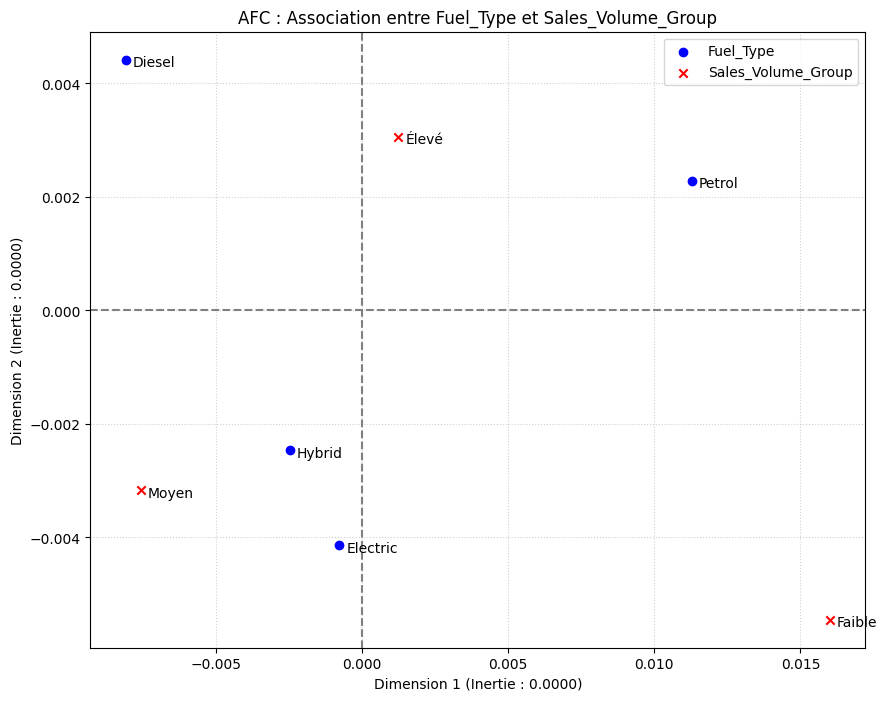

In [83]:
# --- Visualisation (Biplot) ---
plt.figure(figsize=(10, 8))
plt.scatter(row_coords[:, 0], row_coords[:, 1], label=var1, color='blue', marker='o')
plt.scatter(col_coords[:, 0], col_coords[:, 1], label=var2, color='red', marker='x')

# Annoter les points (Fuel_Type)
for i, fuel_type in enumerate(contingency_table.index):
    plt.annotate(fuel_type, (row_coords[i, 0], row_coords[i, 1]), textcoords="offset points", xytext=(5,-5), ha='left')

# Annoter les points (Sales_Classification)
for i, classification in enumerate(contingency_table.columns):
    plt.annotate(classification, (col_coords[i, 0], col_coords[i, 1]), textcoords="offset points", xytext=(5,-5), ha='left')

plt.title(f"AFC : Association entre {var1} et {var2}")
plt.xlabel(f"Dimension 1 (Inertie : {s[0]**2:.4f})")
plt.ylabel(f"Dimension 2 (Inertie : {s[1]**2:.4f})" if len(s) > 1 else "Dimension 2 (N/A)")
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()

print("\n--- Résultats de l'AFC ---")
print(f"Les valeurs propres (inerties) sont : {s**2}")

plt.show()

In [85]:
# AFC pondérée par Sales_Volume - sortie minimale
vals = s**2
pct = vals/vals.sum()*100
print("Dimension 1 inertie:", f"{vals[0]:.2e} ({pct[0]:.2f}%)")
print("Dimension 2 inertie:", f"{vals[1]:.2e} ({pct[1]:.2f}%)")

sales_by_fuel = df.groupby('Fuel_Type')['Sales_Volume'].sum().sort_values(ascending=False)
print("\nVentes totales par type de carburant:")
print(sales_by_fuel)

# Profils relatifs (structure utilisée par l'AFC)
profiles = contingency_table.div(contingency_table.sum(axis=1), axis=0)
print("\nProfils relatifs cad part de chaque groupe de volume dans le carburant:")
print((profiles*100).round(2))

# Résidus standardisés pour voir sur/sous-représentations
expected = np.outer(contingency_table.sum(axis=1), contingency_table.sum(axis=0)) / contingency_table.values.sum()
expected_df = pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns)
std_resid = (contingency_table - expected_df)/np.sqrt(expected_df)
print("\nRésidus standardisés:")
print(std_resid.round(2))

print("\nConclusion:")
print(f"La structure pondérée reste fortement unidimensionnelle (Dim1 {pct[0]:.1f}%). Les carburants avec résidu positif net sur 'Élevé' sont relativement sur-représentés dans les volumes élevés, indépendamment du total global.")


Dimension 1 inertie: 4.97e-05 (80.64%)
Dimension 2 inertie: 1.19e-05 (19.36%)

Ventes totales par type de carburant:
Fuel_Type
Hybrid      64532097
Petrol      63324154
Electric    63157665
Diesel      62361818
Name: Sales_Volume, dtype: int64

Profils relatifs cad part de chaque groupe de volume dans le carburant:
Sales_Volume_Group  Faible  Moyen  Élevé
Fuel_Type                               
Diesel               11.27  33.54  55.20
Electric             11.61  33.53  54.85
Hybrid               11.54  33.54  54.92
Petrol               11.81  32.90  55.28

Résidus standardisés:
Sales_Volume_Group  Faible  Moyen  Élevé
Fuel_Type                               
Diesel              -68.16  21.33  14.62
Electric             12.83  21.26 -22.43
Hybrid               -4.71  22.82 -15.61
Petrol               59.58 -65.44  23.65

Conclusion:
La structure pondérée reste fortement unidimensionnelle (Dim1 80.6%). Les carburants avec résidu positif net sur 'Élevé' sont relativement sur-représentés 